In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Stochastic Environment

In [2]:
n_advertisers = 6
q = np.array([0.9, 0.7, 0.5, 0.6, 0.85, 0.65]) # ad quality
v = np.array([1.0, 1.0, 1.0, 0.85, 1.0, 0.9]) # advertisers value per click
B = 20
n_users = 300

other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers-1, n_users))

n_slots = 3
lmb = np.array([0.6, 0.7, 0.9])

# Truthful Auctions
For truthful auctions with multiple slots we need to use the VCG auction to guarantee the bidders to bid truthful. 

In [3]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [4]:
class VCGAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, values, bids):
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
            Y = sum(np.delete(values, i)*self.lambdas[-self.n_slots+1:])
            X = sum(np.delete(values*self.lambdas, i))
            payments_per_click[i] = (Y-X)/(self.lambdas[i]*self.ctrs[w])
        return payments_per_click.round(2)

In [5]:
# solve optimization problem for optimal bidding strategy
def get_clairvoyant_truthful(B, other_bids, n_users, ctrs, lambdas, values):
    my_valuation = values[0]
    auction = VCGAuction(ctrs, lambdas)
    ## I compute my sequence of utilities at every round
    payments = np.zeros(n_users)
    for t in range(n_users):
        winners, payments_per_click = auction.round(bids=np.append(my_valuation,other_bids[t]))
        if 0 in winners:
            my_slot = np.where(winners == 0)[0]
            payments[t] = payments_per_click[my_slot]

    # greediliy pick best bids
    sorted_round_payments = np.flip(np.argsort(payments)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_payments[i]] = 1
        clairvoyant_payments[sorted_round_payments[i]] = payments[sorted_round_payments[i]]
        clairvoyant_utilities[sorted_round_payments[i]] = my_valuation - payments[sorted_round_payments[i]]
        c += payments[sorted_round_payments[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments


In [6]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [7]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, np.transpose(other_bids), n_users, q, lmb, v)

In [8]:
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=v[0],
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

auction = VCGAuction(q,lmb)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18)
for u in range(n_users):
    my_bid = agent.bid()
    all_bids = np.append(my_bid, np.transpose(other_bids)[u].ravel())
    winners, payments_per_click = auction.round(bids=all_bids)
    if 0 in winners:
        my_slot = np.where(winners == 0)[0]
        c_t = payments_per_click[my_slot]
        f_t = v[0]-c_t
        total_wins+=1
    else:
        c_t,f_t = 0,0
    agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 213


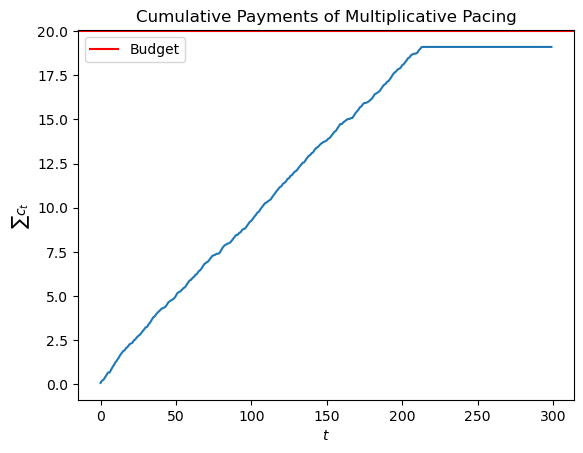

In [9]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

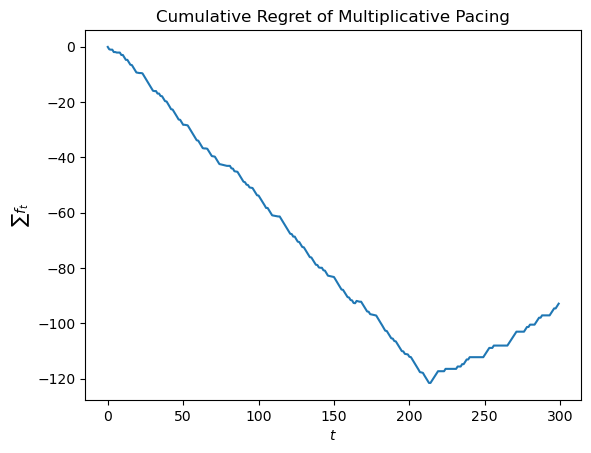

In [10]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()